Preprocessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset (replace 'data.csv' with your file path)
# Assuming the dataset has columns 'EEG_features' (list of PSD, FC features) and 'Label' (categories)
data = pd.read_csv('/content/EEG.machinelearing_data_BRMH.csv')

# Step 1.2: Extract relevant columns
# Identify EEG feature columns by checking column patterns
eeg_feature_columns = [col for col in data.columns if "AB." in col or "COH." in col]
label_column = "main.disorder"  # Main disorder column
metadata_columns = ["sex", "age", "education", "IQ"]  # Optional additional information

# Step 1.3: Split features and labels
X = data[eeg_feature_columns].values  # EEG features
y = data[label_column].values  # Main disorder labels

# Step 1.4: Normalize EEG features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Step 1.5: Encode categorical labels
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output for newer versions
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Step 1.6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

# Print data shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (756, 1140), y_train shape: (756, 7)
X_test shape: (189, 1140), y_test shape: (189, 7)


Define the Conditional VAE Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define latent space dimensions
input_dim = X_train.shape[1]  # Number of EEG features
latent_dim = 10  # Adjustable parameter
condition_dim = y_train.shape[1]  # Number of one-hot encoded labels

# Step 2.1: Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder_layer = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
        ])
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.encoder_layer(inputs)
        return self.z_mean(x), self.z_log_var(x)

# Step 2.2: Decoder
class Decoder(Model):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder_layer = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(output_dim, activation='sigmoid'),
        ])

    def call(self, z):
        return self.decoder_layer(z)

# Step 2.3: Conditional VAE with reparameterization trick
class CVAE(Model):
    def __init__(self, latent_dim, input_dim, condition_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim + condition_dim, input_dim)
        self.latent_dim = latent_dim

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs, labels):
        conditioned_input = tf.concat([inputs, labels], axis=1)
        z_mean, z_log_var = self.encoder(conditioned_input)
        z = self.sample(z_mean, z_log_var)
        conditioned_z = tf.concat([z, labels], axis=1)
        reconstructed = self.decoder(conditioned_z)
        return reconstructed, z_mean, z_log_var

# Instantiate the model
cvae = CVAE(latent_dim=latent_dim, input_dim=input_dim, condition_dim=condition_dim)

Loss Function and Training

In [8]:
# Step 3.1: Define loss function
def vae_loss(x, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstructed))
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Step 3.2: Training step
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        reconstructed, z_mean, z_log_var = cvae(inputs, labels)
        loss = vae_loss(inputs, reconstructed, z_mean, z_log_var)
    gradients = tape.gradient(loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    return loss

# Step 3.3: Training loop
epochs = 50
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

for epoch in range(epochs):
    for inputs, labels in train_dataset:
        loss = train_step(inputs, labels)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy():.4f}")


Epoch 1, Loss: 1.4272
Epoch 2, Loss: 1.0891
Epoch 3, Loss: 1.0763
Epoch 4, Loss: 1.0739
Epoch 5, Loss: 1.0677
Epoch 6, Loss: 1.0661
Epoch 7, Loss: 1.0658
Epoch 8, Loss: 1.0643
Epoch 9, Loss: 1.0679
Epoch 10, Loss: 1.0655
Epoch 11, Loss: 1.0663
Epoch 12, Loss: 1.0655
Epoch 13, Loss: 1.0661
Epoch 14, Loss: 1.0653
Epoch 15, Loss: 1.0657
Epoch 16, Loss: 1.0651
Epoch 17, Loss: 1.0644
Epoch 18, Loss: 1.0664
Epoch 19, Loss: 1.0645
Epoch 20, Loss: 1.0657
Epoch 21, Loss: 1.0651
Epoch 22, Loss: 1.0670
Epoch 23, Loss: 1.0643
Epoch 24, Loss: 1.0710
Epoch 25, Loss: 1.0648
Epoch 26, Loss: 1.0636
Epoch 27, Loss: 1.0652
Epoch 28, Loss: 1.0637
Epoch 29, Loss: 1.0631
Epoch 30, Loss: 1.0651
Epoch 31, Loss: 1.0606
Epoch 32, Loss: 1.0660
Epoch 33, Loss: 1.0643
Epoch 34, Loss: 1.0643
Epoch 35, Loss: 1.0645
Epoch 36, Loss: 1.0651
Epoch 37, Loss: 1.0653
Epoch 38, Loss: 1.0638
Epoch 39, Loss: 1.0639
Epoch 40, Loss: 1.0644
Epoch 41, Loss: 1.0643
Epoch 42, Loss: 1.0655
Epoch 43, Loss: 1.0644
Epoch 44, Loss: 1.06

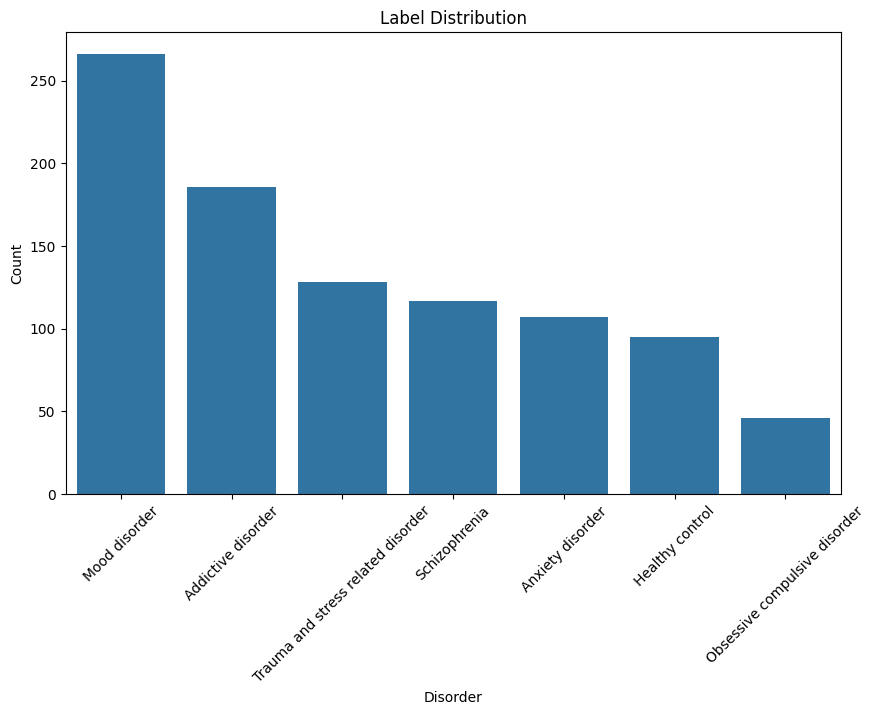

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `data['main.disorder']` contains labels
label_counts = data['main.disorder'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Disorder")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


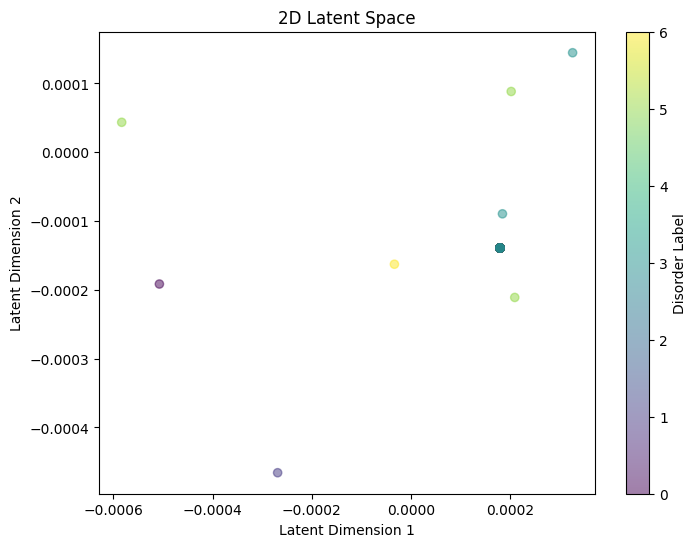

In [11]:
import numpy as np

# Get latent variables for training data
z_means, _ = cvae.encoder(tf.concat([X_train, y_train], axis=1))

# Convert TensorFlow tensors to NumPy arrays
z_means = z_means.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(z_means[:, 0], z_means[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.5)
plt.colorbar(label='Disorder Label')
plt.title("2D Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


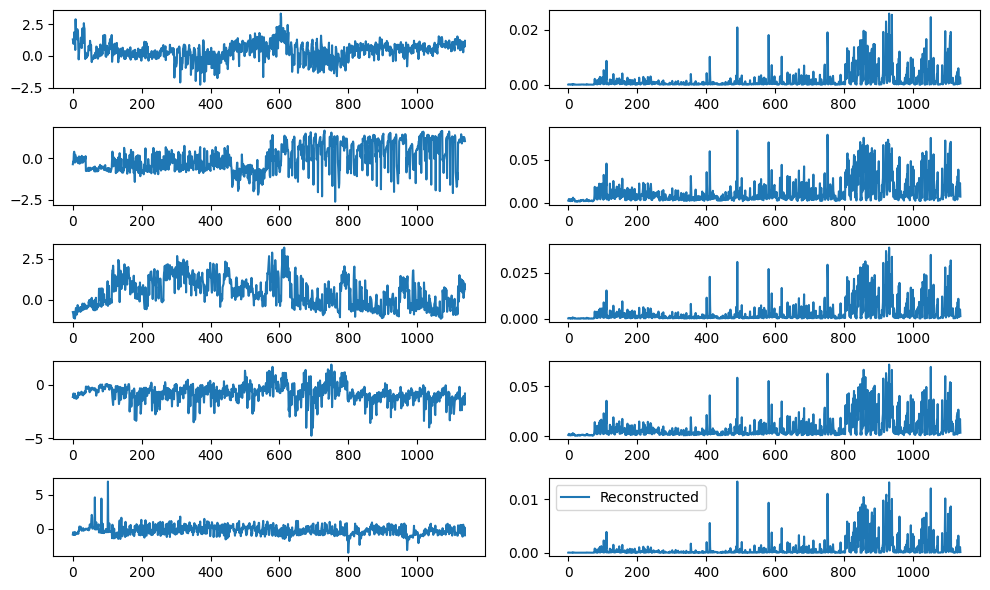

In [12]:
# Reconstruct the first few samples from the test set
original = X_test[:10]
labels = y_test[:10]
reconstructed, _, _ = cvae(tf.convert_to_tensor(original), tf.convert_to_tensor(labels))

# Convert TensorFlow tensors to NumPy arrays
reconstructed = reconstructed.numpy()

# Plot original vs reconstructed features
plt.figure(figsize=(10, 6))
for i in range(5):  # Show 5 samples
    plt.subplot(5, 2, i*2 + 1)
    plt.plot(original[i], label="Original")
    plt.subplot(5, 2, i*2 + 2)
    plt.plot(reconstructed[i], label="Reconstructed")
plt.legend()
plt.tight_layout()
plt.show()


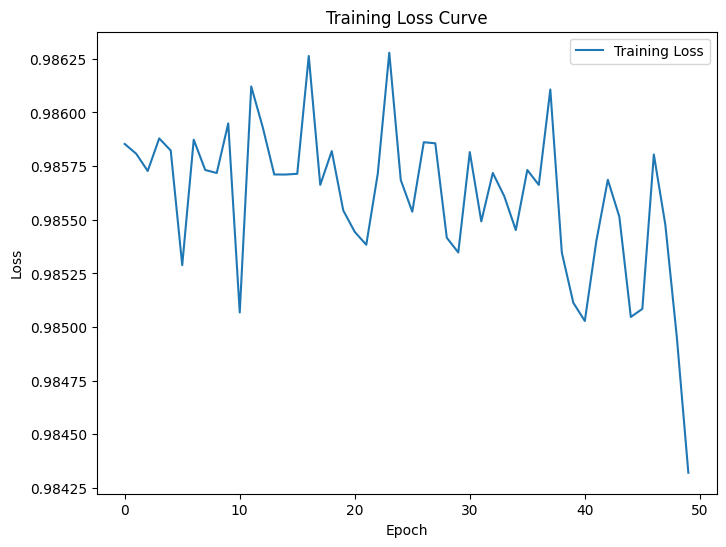

In [13]:
# Assuming `losses` contains loss values for each epoch
losses = []

# During training, append the loss after each epoch
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataset:
        loss = train_step(inputs, labels)
        epoch_loss += loss.numpy()
    losses.append(epoch_loss / len(train_dataset))

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


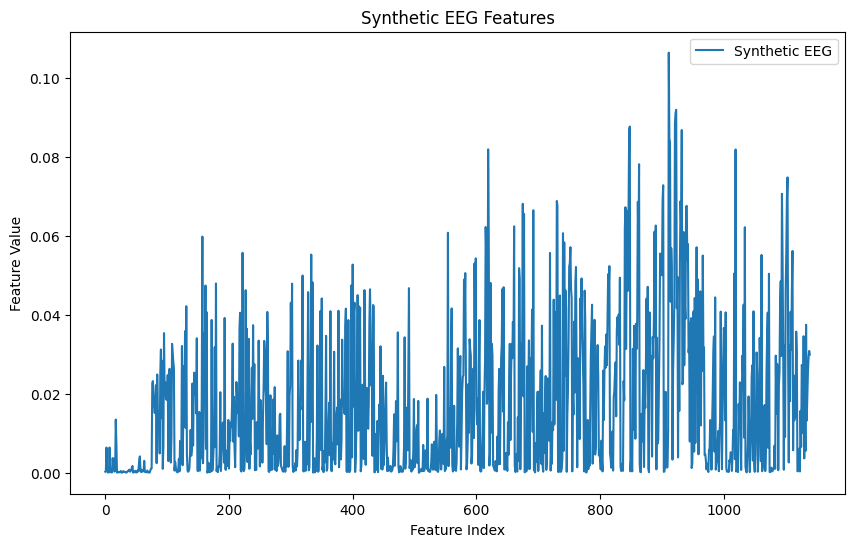

In [14]:
# Generate synthetic data conditioned on a specific label
condition_label = np.zeros((1, y_train.shape[1]))
condition_label[0, 0] = 1  # Condition on the first label
random_latent = np.random.normal(size=(1, latent_dim))
synthetic = cvae.decoder(tf.concat([random_latent, condition_label], axis=1))

# Plot the generated EEG features
plt.figure(figsize=(10, 6))
plt.plot(synthetic.numpy().flatten(), label="Synthetic EEG")
plt.title("Synthetic EEG Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()
